In [25]:
using Distributions
using StatPlots
using Plots
pyplot(size = (600,400))

Plots.PyPlotBackend()

In [2]:
include("src/NGSIM.jl")

chmm_em! (generic function with 1 method)

In [3]:
K = 3
D = 2

# doesn't line up in format with NGSIM data (specifically, no time/frame aspect)
model = rand_chmm(K, D)
(X, Z, traj_ptr, traj_pairs_full) = rand_trajs(model, 
    T_range=50:1_000, N_pairs=2_000)
num_trajs = length(traj_ptr) - 1
num_obs = size(X, 2)

2086364

In [4]:
# make fake data like NGSIM
r = zeros(num_obs)
c = zeros(num_obs)

T = 0
for (i, (i1, i2)) in enumerate(traj_pairs_full)
    s1 = traj_ptr[i1]
    e1 = traj_ptr[i1+1]-1
    
    s2 = traj_ptr[i2]
    e2 = traj_ptr[i2+1]-1
    
    @assert (e2-s2) == (e1-s1)
    dT = length(s2:e2)
    
    r[s1:e1] = T+(1:dT)
    r[s2:e2] = T+(1:dT)
    T += dT
    
    i = sub2ind((2, num_trajs), 1, i)
    c[s1:e1] = i
    c[s2:e2] = i+1
end

S = sparse(r, c, X[1,:])

@assert all(S.colptr .== traj_ptr)

num_pairs = round(Int, length(traj_pairs_full) / 1)
pairs = zeros(Int, 4, num_pairs)
for (i, ind) in enumerate(randperm(length(traj_pairs_full))[1:num_pairs])
    c1, c2 = traj_pairs_full[ind]
    pairs[1:2, i] = [c1, c2]
    pairs[3, i] = S.rowval[traj_ptr[c1]] + rand(1:10)
    pairs[4, i] = S.rowval[traj_ptr[c1+1]-1] - rand(1:10)
end

## EM

In [5]:
curr = chmm_from_data(X, K)
orig = copy(curr)
suff = ChmmSuffStats(curr)
;

In [6]:
(curr, log_like_hist) = chmm_em!(S, X, pairs, K, curr, suff; N_iters=25, print_every=5)
;

iteration      5:  -13984431.166
iteration     10:  -13954006.510
iteration     15:  -13952830.518
iteration     20:  -13952795.736
iteration     25:  -13952795.005



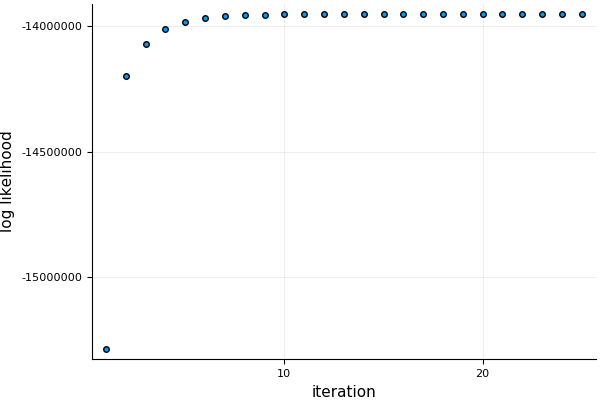

In [26]:
scatter(log_like_hist, legend=false)
ylabel!("log likelihood")
xlabel!("iteration")

In [24]:
@assert all( diff(log_like_hist) .> 0 )


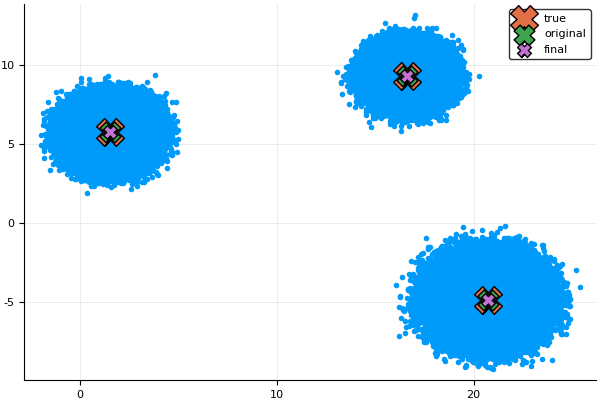

In [32]:
m = hcat(model.μs...)'
mo = hcat(orig.μs...)'
mhat = hcat(curr.μs...)'

scatter(X[1, :], X[2, :], label="", marker=(:circle, stroke(0)))
scatter!(m[:, 1], m[:, 2], marker=:X, ms=20, label="true")
scatter!(mo[:, 1], mo[:, 2], marker=:X, ms=15, label="original")
scatter!(mhat[:,1], mhat[:, 2], marker=:X, ms=10, label="final")

# Analysis

In [9]:
true_to_est = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est[i] = indmin(r)
end
true_to_est_full = vec(outer(true_to_est))
;

## P

In [10]:
#
# factor true dist
#

P_true = copy(model.P)
P_single = zeros(K, K, K)

for i in 1:K
    for j in 1:i
        k = sub2ind((K, K), i, j)
        A = square_view(P_true, K, :, k)
        p1, p2 = estimate_outer_double(A)
        
        P_single[:, i, j] = p1        
        P_single[:, j, i] = p2
    end
end

In [11]:
#
# factor est
#

P_hat = curr.P[true_to_est_full, true_to_est_full]
P_single_hat = zeros(K, K, K)

for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = square_view(P_hat, K, :, k1) + square_view(P_hat, K, :, k1)'
        p1, p2 = estimate_outer_double(A)
        
        P_single_hat[:, i, j] = p1        
        P_single_hat[:, j, i] = p2
    end
end

In [12]:
# full
(mean(P_true .- P_hat), std(P_true .- P_hat))

(0.02045202921187214, 0.1420441518790101)

In [13]:
# factored
(mean(P_single .- P_single_hat), std(P_single .- P_single_hat))

(-2.05596856412066e-17, 0.20951000004590498)


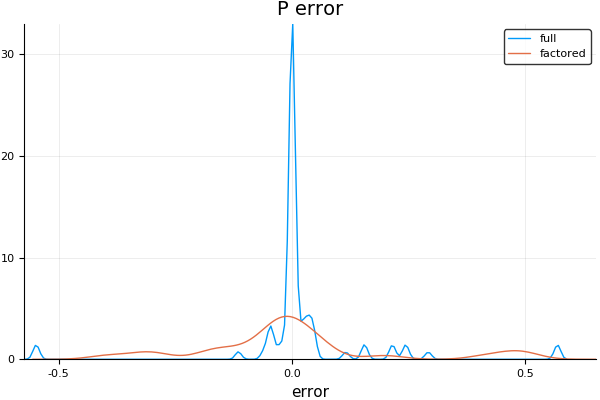

In [27]:
plot(vec(P_true .- P_hat), seriestype=:density, label="full")
plot!(vec(P_single .- P_single_hat), seriestype=:density, label="factored", xlabel="error")
title!("P error")

## π₀

In [15]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_full] )
(mean(p0_true .- p0_hat), std(p0_true .- p0_hat))

(0.0038754327911052944, 0.06351688033833716)


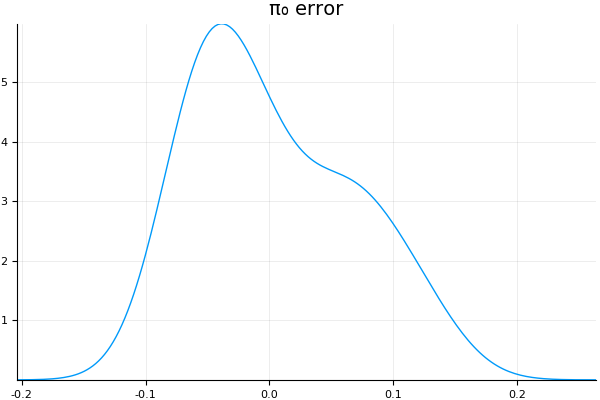

In [28]:
plot(vec(p0_true .- p0_hat), seriestype=:density, legend=false)
title!("π₀ error")

## μs

In [17]:
m_errs = [vec((model.μs[i] .- curr.μs[true_to_est[i]])./model.μs[i]) for i in 1:K]
hcat(m_errs ...)

2×3 Array{Float64,2}:
  5.9384e-5   -0.000309608  -3.06394e-5 
 -5.52661e-5   4.25172e-5    0.000227916


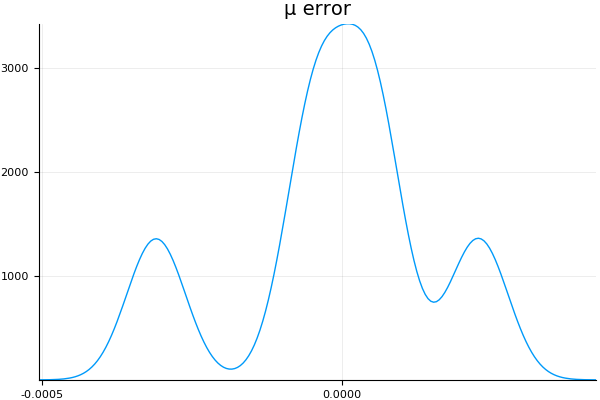

In [29]:
plot(vcat(m_errs...), seriestype=:density, legend=false)
title!("μ error")

## Σs

In [30]:
S_errs = [vec( model.Σs[i] .- curr.Σs[true_to_est[i]] ) for i in 1:K]
[map(mean, S_errs) map(std, S_errs)]

3×2 Array{Float64,2}:
 -0.00119095   0.00110673 
  0.000525872  0.000860243
  8.16153e-5   0.000629823


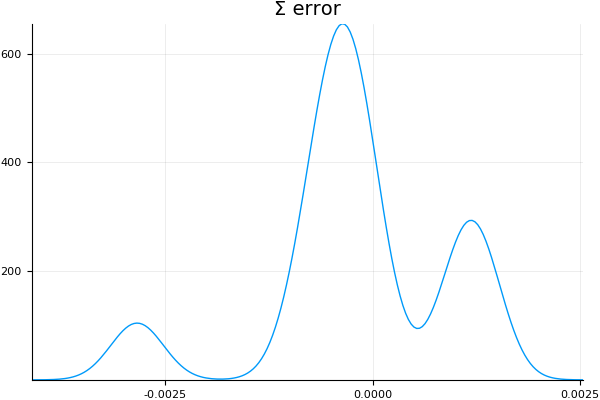

In [31]:
plot(vcat(S_errs...), seriestype=:density, legend=false)
title!("Σ error")